# Import the Normalized Database

In [1]:
import numpy as np 
db = np.load('db_5SS_norm_s7408.npz')
print(db['cplrData'].shape)
print(db['mechData'].shape)
cplr=db['cplrData']
mech=db['mechData']

(7408, 100, 3)
(7408, 11, 3)


In [2]:
#%matplotlib inline
%matplotlib notebook

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from numpy import linalg as LA
#plt.style.use('dark_background')


def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))
    
def visualizePaths(Paths,rows=10,cols=3):
    path_index=0;
    fig = plt.figure(figsize=2*plt.figaspect(rows/cols))
    for i in range(rows):
        for j in range(cols):
            Pts=Paths[path_index]
            path_index=path_index+1
            ax = fig.add_subplot(rows, cols, path_index, projection='3d')
            plotPath(Pts, ax, .5)
            #plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


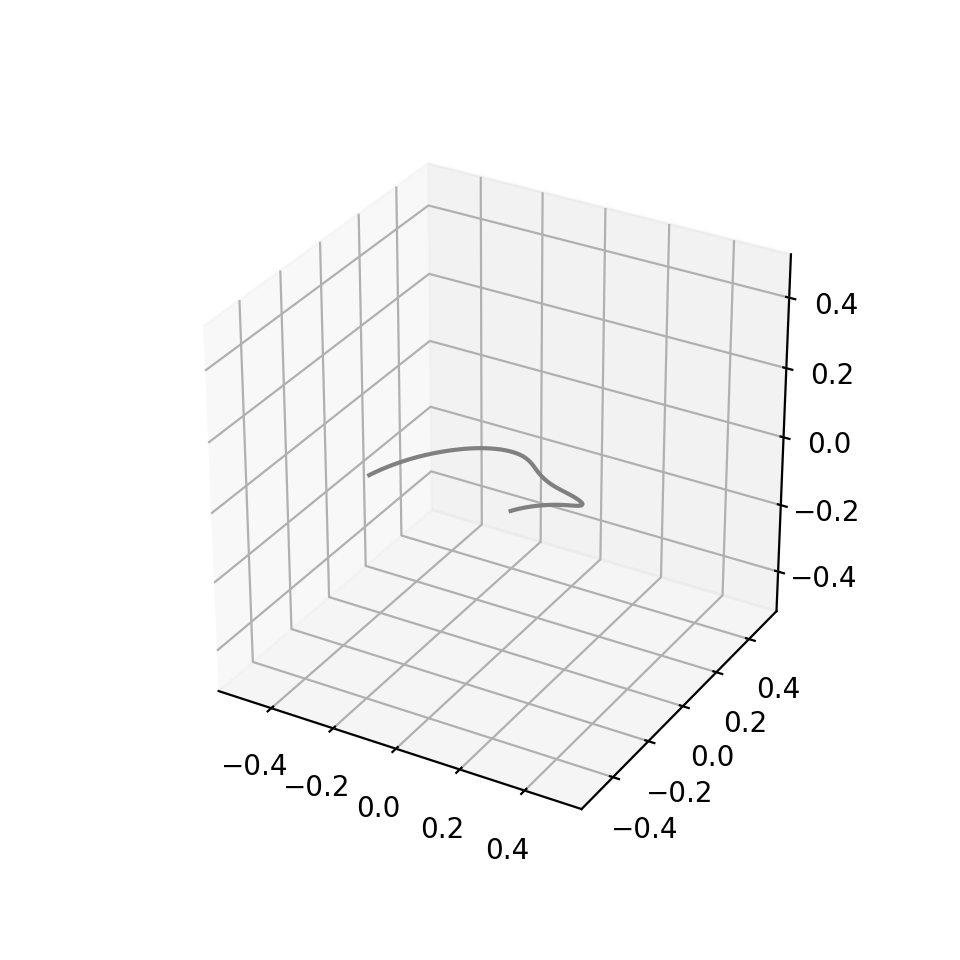

In [3]:
Pts=cplr[21]
fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(Pts, ax, .5)

# Data Cleanup: Filtering Incorrect Coupler paths generated by the solver

When the solver is simulating a 5ss-mechanism, it may jump from one branch to another. This is due to inherent limitations of numerical methods of converging into a local minima. These paths have extremely high curvature/torsion at points where the branch jumping happens. 

Thus, we filter these invalid paths generated by the solver due to branch jump during simulation using curvature and torsion outliers. To detect and remove this incorrect data, we use the z-score.

In [4]:
# Find a b-spline curve with its differentials
from scipy import interpolate
def calcCurveProp(path):
    xp=path[:,0]
    yp=path[:,1]
    zp=path[:,2]
    u_fine = np.linspace(0,1,100)
    tck, u =interpolate.splprep([xp,yp,zp],s=.001,k=4)
    x, y, z = interpolate.splev(u_fine, tck)
    Path= np.vstack(([x],[y],[z])).T
    x_d, y_d, z_d = interpolate.splev(u_fine, tck, der=1)
    Path_d= np.vstack(([x_d],[y_d],[z_d])).T
    x_dd, y_dd, z_dd = interpolate.splev(u_fine, tck, der=2)
    Path_dd= np.vstack(([x_dd],[y_dd],[z_dd])).T
    x_ddd, y_ddd, z_ddd = interpolate.splev(u_fine, tck, der=3)
    Path_ddd= np.vstack(([x_ddd],[y_ddd],[z_ddd])).T
    return Path, Path_d, Path_dd, Path_ddd

def calcFrenetFrame(path):
    Path, Path_d, Path_dd, Path_ddd= calcCurveProp(path)
    T,N,B=[],[],[]
    for i in range(len(path)):
        T.append(Path_d[i]/np.linalg.norm(Path_d[i]))
        num=np.cross(Path_d[i],np.cross(Path_dd[i],Path_d[i]))
        den=np.linalg.norm(Path_d[i])*np.linalg.norm(np.cross(Path_dd[i],Path_d[i]))
        N.append(num/den)
        B.append(np.cross(T[i],N[i]))
    return np.array(T), np.array(N), np.array(B)

def calcCurvatureTorsion(path):
    Path, Path_d, Path_dd, Path_ddd= calcCurveProp(path)
    K,T=[],[]
    for i in range(len(path)):
        vec=np.cross(Path_d[i],Path_dd[i])
        curv=np.linalg.norm(vec)/(np.linalg.norm(Path_d[i])**3)
        tors=np.dot(vec,Path_ddd[i])/(np.linalg.norm(vec)**2)
        K.append(curv)
        T.append(tors)
    return K,T

# Plot a curve and its Curvature,Torsion
def plotFrenetDesc(path,Curvature,Torsion):
    fig = plt.figure(figsize=.9*plt.figaspect(1/2))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    plotPath(path, ax, .5)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(range(len(Curvature)), Curvature);
    ax.plot(range(len(Torsion)), Torsion);
    plt.grid(True)
    #plt.ylim(0, 10);
    plt.show()

def calcDB_CurvTor(cplr):
    K=[] #Curvature
    T=[] #Torsion
    for i in range(len(cplr)):
        Ki,Ti=calcCurvatureTorsion(cplr[i])
        K.append(Ki)
        T.append(Ti)
    return K,T

def calcDB_minmaxCurvTor(K,T):
    maxK=[]
    minK=[]
    maxT=[]
    minT=[]
    for i in range(len(K)):
        maxK.append(np.max(K[i]))
        minK.append(np.min(K[i]))
        maxT.append(np.max(T[i]))
        minT.append(np.min(T[i]))
    print("Max Curvature: "+ str(np.max(maxK)) +" , Index: " +str(np.argmax(maxK)))
    print("Min Curvature: "+ str(np.min(minK)) +" , Index: " +str(np.argmin(minK)))
    print("Max Torsion: "+ str(np.max(maxT)) +" , Index: " +str(np.argmax(maxT)))
    print("Min Torsion: "+ str(np.min(minT)) +" , Index: " +str(np.argmin(minT)))
    return maxK,minK,maxT,minT

In [5]:
# Find the Curvature and Torsion for DB
K,T=calcDB_CurvTor(cplr)
# Analyze min-max
maxK,minK,maxT,minT=calcDB_minmaxCurvTor(K,T)

Max Curvature: 41806.97291908582 , Index: 4480
Min Curvature: 0.003247088409600386 , Index: 521
Max Torsion: 5619.002494606576 , Index: 521
Min Torsion: -4148.169216793949 , Index: 4940


<IPython.core.display.Javascript object>


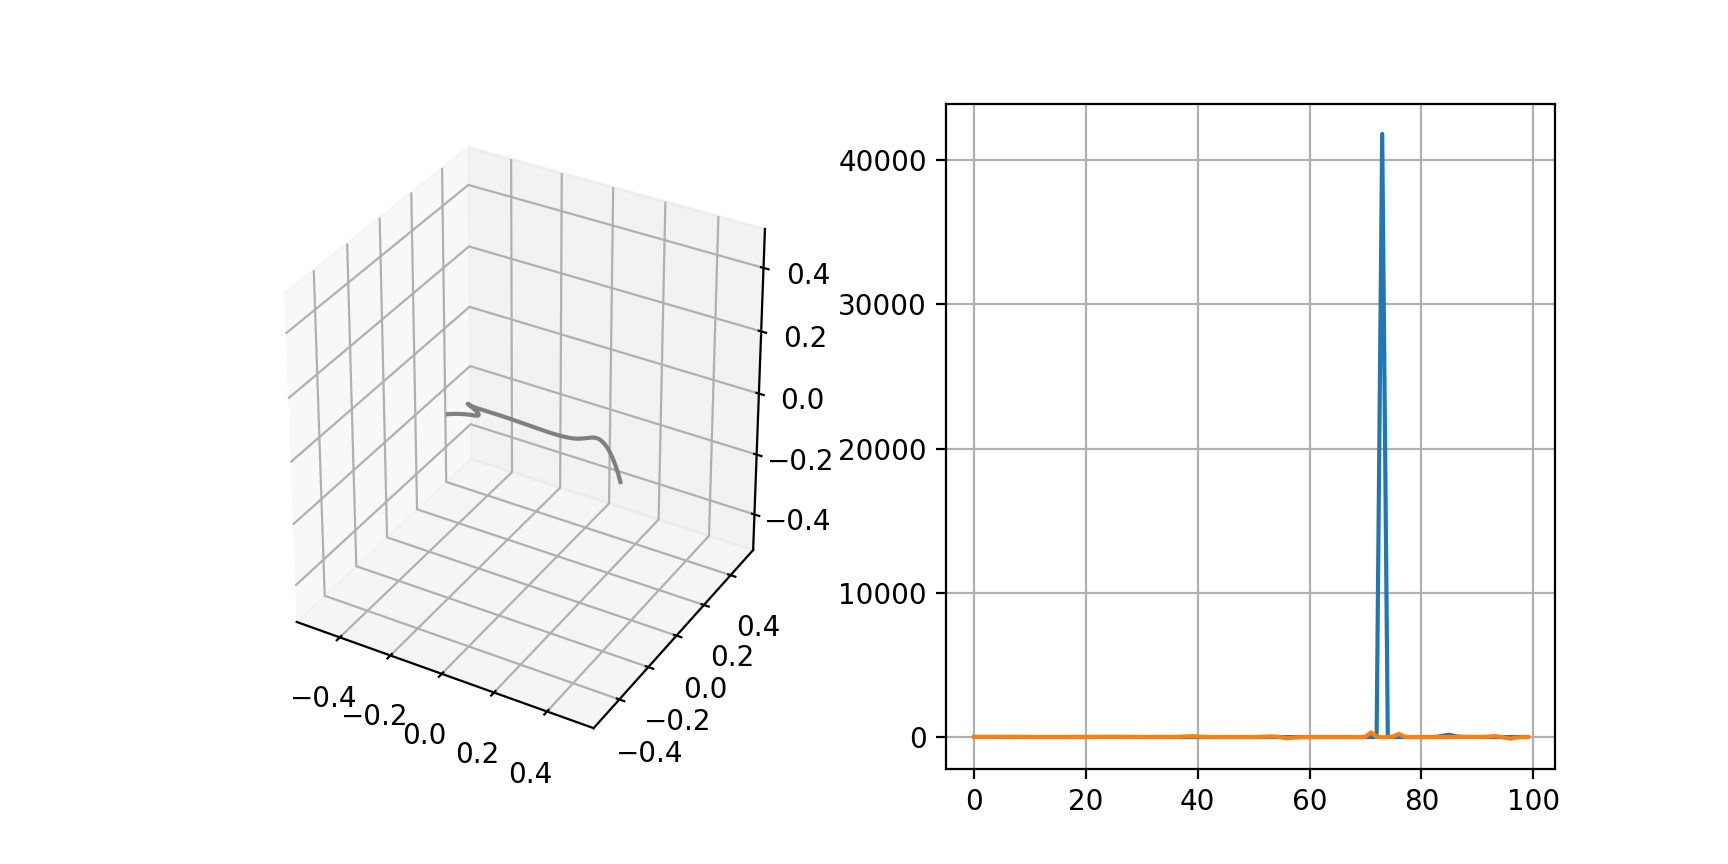

array([[ 0.0611434 ,  0.14895852, -0.56169134],
       [-0.36236231, -0.3911433 , -0.14701303],
       [-0.64814467, -0.58581909, -0.28097004],
       [ 0.32583947,  0.10736489, -0.0464756 ],
       [-0.12451337,  0.54191661, -0.09878923],
       [-0.38938952,  0.25538135,  0.35824031],
       [-0.43890638, -0.46331969,  0.74389826],
       [-0.42637183,  0.68802984,  0.40781693],
       [-0.09457254,  0.58974414, -0.29536368],
       [-0.8668635 , -0.15098046,  0.15932129],
       [-0.18526057,  0.00441464,  0.00658781]])

In [6]:
# Plot Coupler curve and its Descriptors
index=4480
Pts=cplr[index]
Ki=K[index]
Ti=T[index]
plotFrenetDesc(Pts,Ki,Ti)

# Check simulation in Matlab
mech[index]

In [7]:
def visualizeCurTorHist(maxK, maxT, minT):
    # Visualize Curvature
    fig = plt.figure(figsize=1*plt.figaspect(1/1.9))
    ax = fig.add_subplot(1, 3, 1)
    n, bins, patches = ax.hist(maxK, 50, facecolor='blue', alpha=0.5)
    print(np.array(n, dtype='int'))

    # Visualize Torsion
    ax = fig.add_subplot(1, 3, 2)
    n, bins, patches = ax.hist(maxT, 50, facecolor='blue', alpha=0.5)
    print(np.array(n, dtype='int'))

    ax = fig.add_subplot(1, 3, 3)
    n, bins, patches = ax.hist(minT, 50, facecolor='blue', alpha=0.5)
    plt.show()
    print(np.array(n, dtype='int'))
    plt.tight_layout(pad=.1)

<IPython.core.display.Javascript object>


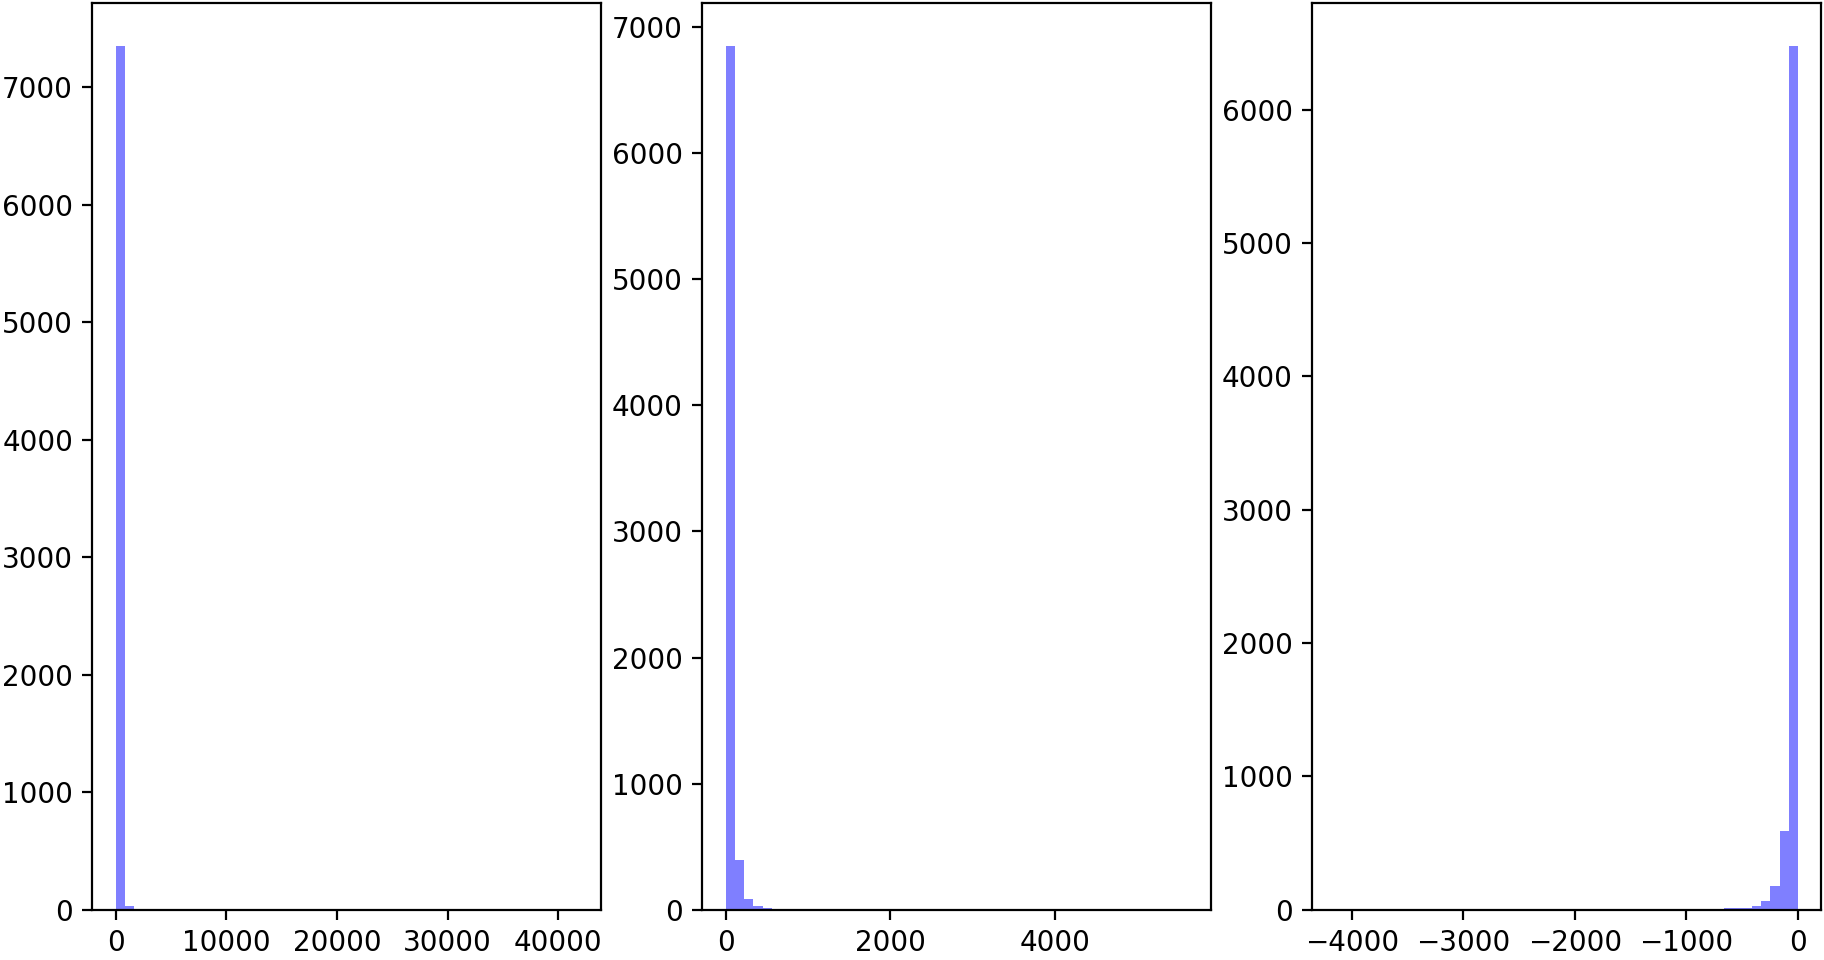

[7350   33    6    5    4    3    2    0    0    1    0    1    0    0
    1    0    0    0    0    0    0    0    0    0    0    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    1]
[6850  396   82   33   18    6   10    5    1    2    0    0    1    0
    0    1    0    0    0    0    0    0    1    0    0    0    0    0
    0    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    1]
[   1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    1    0    0
    2    0    0    0    1    1    0    2    1    2    2    1    2    4
   10   14   14   31   68  182  589 6479]


In [8]:
visualizeCurTorHist(maxK, maxT, minT)

In [9]:
# Remove outliers
from scipy.stats import zscore
def dbCleanup(cplr,maxK,maxT,minT):
    n=len(cplr)
    z_maxK=zscore(np.append(maxK,-np.array(maxK)))[0:n]
    z_maxT=zscore(np.append(maxT,-np.array(maxT)))[0:n]
    z_minK=zscore(np.append(minT,-np.array(minT)))[0:n]
    thresh=3 # Threshold is 4-sigma for Torsion, 2-sigma for curvature
    
    new_cplr=cplr[(z_maxK<thresh/2) & (z_maxT<thresh) & (z_minK>-thresh)]
    n_outliers=np.where(((z_maxK<thresh/2) & (z_maxT<thresh) & (z_minK>-thresh))==0)
    #print(n_outliers)
    print("Number of outliers= "+str(n_outliers[0].shape[0]))
    print("Size of cleaned db= "+str(new_cplr.shape[0]))
    return new_cplr

new_cplr=dbCleanup(cplr,maxK,maxT,minT)

Number of outliers= 208
Size of cleaned db= 7200


In [10]:
nK,nT=calcDB_CurvTor(new_cplr)
nmaxK,nminK,nmaxT,nminT=calcDB_minmaxCurvTor(nK,nT)

Max Curvature: 921.6874180712069 , Index: 2573
Min Curvature: 0.006082946291918266 , Index: 4062
Max Torsion: 340.3327107151242 , Index: 2990
Min Torsion: -324.70119744839053 , Index: 4854


<IPython.core.display.Javascript object>


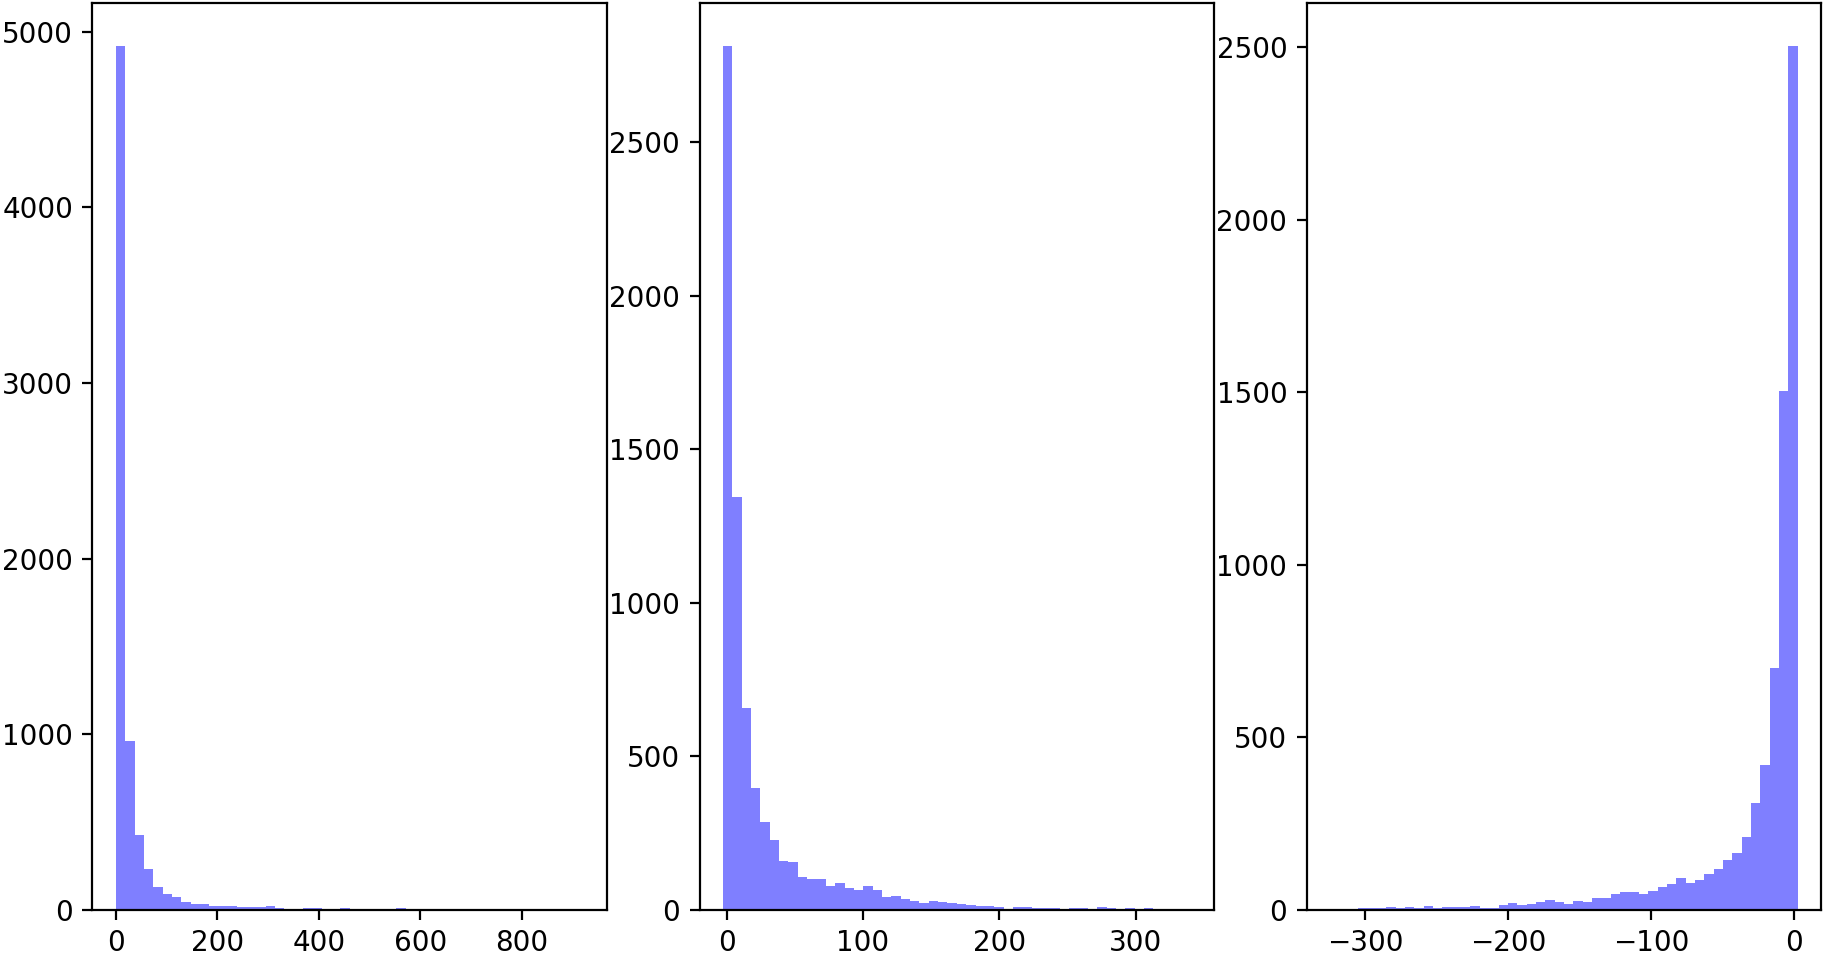

[4919  962  424  231  131   90   72   43   34   34   20   22   21   13
   16   18   21    9    6    5   10    8    7    6    8    3    3    5
    3    3    8    4    3    2    5    1    5    5    3    1    1    1
    1    2    5    1    0    1    2    2]
[2814 1346  656  397  286  226  160  156  106  100   99   76   87   71
   65   79   64   43   44   36   29   23   29   26   22   19   14   11
   12    8    3    9   10    6    6    7    4    5    6    1    8    5
    4    7    2    5    1    1    3    3]
[   3    3    1    6    5    4    8    4    9    5   10    6    8    7
    7   11    5    5   14   19   13   17   22   29   23   18   25   22
   33   34   47   51   51   47   55   66   75   91   77   85  103  119
  144  164  212  308  420  702 1504 2503]


In [11]:
visualizeCurTorHist(nmaxK, nmaxT, nminT)

<IPython.core.display.Javascript object>


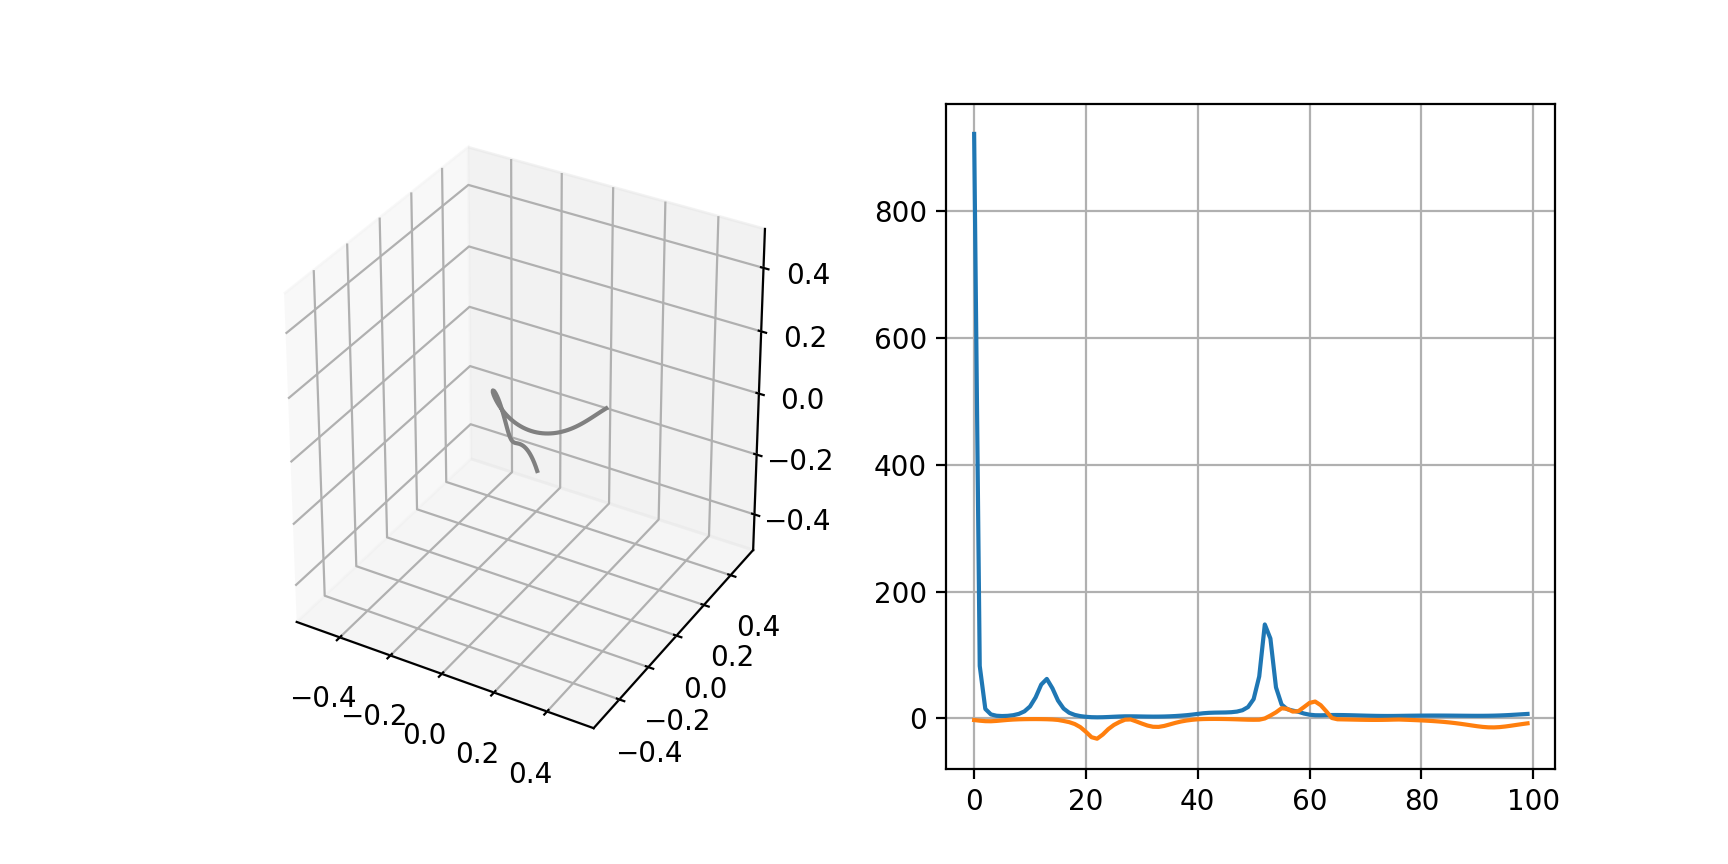

array([[ 0.18131877,  0.07020211, -0.03920559],
       [-0.04430546,  0.39068339,  0.20146187],
       [-0.08584836, -0.07118828, -0.01962056],
       [-0.15270108,  0.21841325, -0.11371486],
       [-0.01474708,  0.28542963,  0.26142052],
       [ 0.01174499, -0.08364747,  0.29896465],
       [ 0.2066973 ,  0.33862721, -0.0486941 ],
       [-0.0678382 ,  0.17785799, -0.18432971],
       [ 0.14515485,  0.21508404,  0.28560652],
       [ 0.0265133 , -0.09023262,  0.30506496],
       [-0.19384363, -0.00557952, -0.02342222]])

In [12]:
# Plot Coupler curve and its Descriptors
index=2573
Pts=new_cplr[index]
Ki=nK[index]
Ti=nT[index]
plotFrenetDesc(Pts,Ki,Ti)

# Check simulation in Matlab
mech[index]

In [39]:
np.savez('db_5SS_clean_s7200', cplrData=new_cplr) 

# Data balancing using undersampling: remove similar paths to enhance variety

In its present state, the database has more samples of coupler paths which are more probable while lesser samples of other more diverse. However, we would like our NN to handle all types of coupler paths with same efficiency and accuracy. To overcome this bias, we select a limited number of diverse paths from the complete database. Thus, this new balanced dataset contains equal samples of unique and diverse paths.

## Basic P2 Norm(NOT USED)

We use P2 norm of difference between two curves as the metric to compare the similarity between two curves. This metric cannot detect same curves which have undergone transformation like translation, rotation or scaling. However, since we have already done that in the preprocessing, it works as a good metric. To check for parametrization in inverse direction, we also check the flipped paths to compare P2 norm. Unfortunately, partial matching is not possible with this metric.

In [13]:
def compareEqualCurve(path1, path2):
    delta1=LA.norm(path1-path2)/len(path1)
    #return delta1
    delta2=LA.norm(path1-np.fliplr(path2))/len(path1) #for inverse time parametrization
    return np.array([delta1,delta2]).min()
    

def findDiverseP2norm(pathdb, threshold):
    DiverseCplr=np.array([pathdb[0]])
    for i in range(1,len(pathdb)):
        if i%500==0:
            print("Paths Processed:"+ str(i)+" ,unique Paths in DB:"+str(DiverseCplr.shape[0]))
        
        path1=pathdb[i]
        diff=np.array([])
        for path2 in DiverseCplr:
            diff=np.append(diff,[compareEqualCurve(path1, path2)])
        
        if diff.min()>threshold:
            DiverseCplr=np.append(DiverseCplr,[path1], axis=0)
    
    print("Database size before removing similar paths: " + str(cplr.shape[0]))
    print("Database size after removing similar paths: " + str(DiverseCplr.shape[0]))
    return DiverseCplr

In [14]:
#DiverseCplr=findDiverseP2norm(cplr, .001)

In [15]:
#visualizePaths(DiverseCplr)

<IPython.core.display.Javascript object>


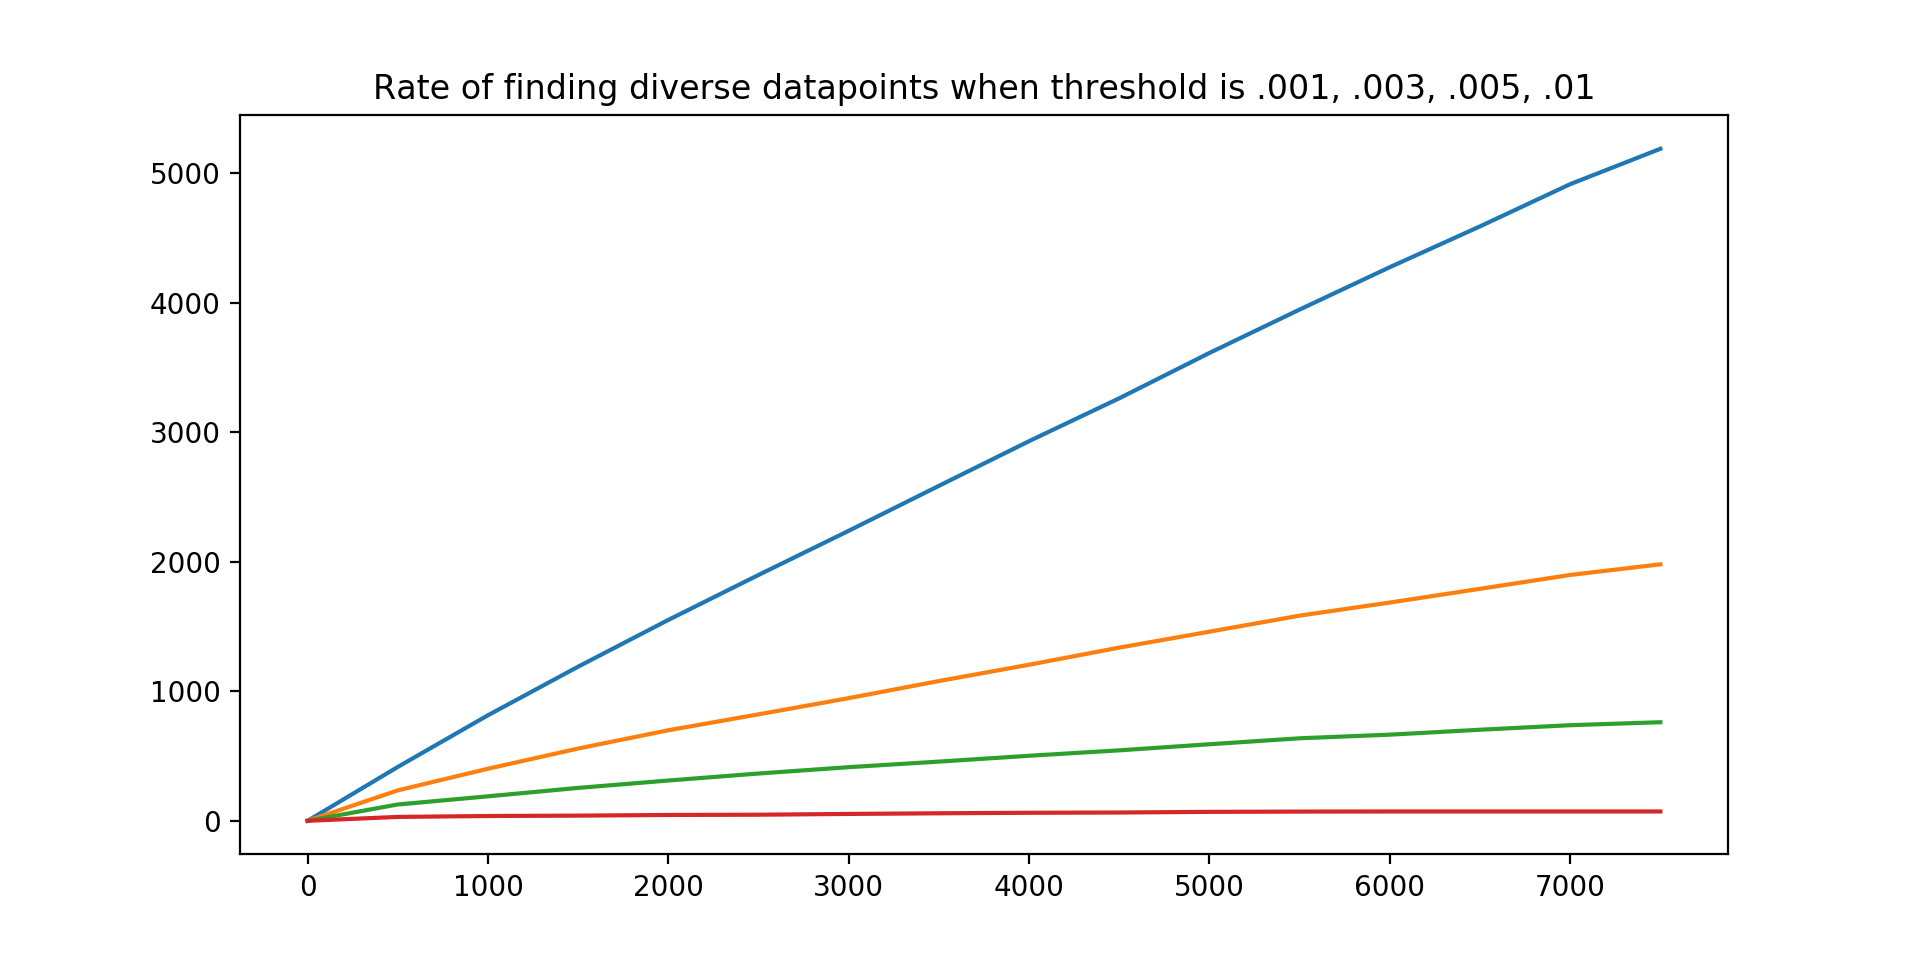

Text(0.5, 1.0, 'Rate of finding diverse datapoints when threshold is .001, .003, .005, .01')

In [16]:
# Rate at which diverse data is added
# Ideally, to represent all of the curves, data should be added until the plot saturates
x=range(0,8000,500)
y_001=[0,416,815,1190,1551,1898,2239,2586,2931,3262,3612,3947,4274,4589,4915,5188]
y_003=[0,235,402,558,699,822,947,1079,1205,1337,1460,1584,1685,1791,1898,1980]
y_005=[0,126,189,254,311,365,414,457,502,544,591,637,665,703,738,761]
y_01=[0,30,37,40,45,47,53,58,62,64,69,71,72,72,72,72]
fig = plt.figure(figsize=plt.figaspect(1/2))
ax = fig.add_subplot(111)
ax.plot(x,y_001)
ax.plot(x,y_003)
ax.plot(x,y_005)
ax.plot(x,y_01)
ax.set_title("Rate of finding diverse datapoints when threshold is .001, .003, .005, .01")

## Frenet frame descriptors (P2 norm of Curvature and Torsion)

According to the "fundamental theorem of space curves" in differential geometry, every regular curve in three-dimensional space, with non-zero curvature, has its shape (and size) completely determined by its curvature and torsion. Thus, a better metric to compare the similarity of two curves are these Frenet–Serret Descriptors. The curvature is always positive while the torsion can be negative.

These descriptors are invariant to spatial translation and rotation. However, they are not scaling invariant. If the curve is scaled uniformly $\alpha$ times, the curvature and torsion scales $\frac{1}{\alpha}$ times. Thus, matching at same scale is possible. Also, the Frenet–Serret descritors can be successfully used to compare two curves of unequal length and match them when one is a part of another. This approach is thus better than the P2 norm comparision.

Intrestingly, the intregral of curvature are scaling invariant in addition to translation and rotation and thus could be used for partial curve comparision. Also, numerical calculation of torsion can end up being extremely inaccurate. Thus, we use only curvature to filter out similar paths

In [17]:
def compareCurvTorMetric(K1, K2, T1, T2):
    # We compute sum of p-2 norms of difference in Curvature and torsion
    K1,K2,T1,T2=np.array(K1),np.array(K2),np.array(T1),np.array(T2)
    n_pts=len(K1)
    wt_const=.1
    
    d_K=LA.norm(K1-K2)
    d_T=LA.norm(T1-T2)
    delta1=(d_K+wt_const*d_T)/n_pts
    
    d_Kf=LA.norm(K1-np.flipud(K2))
    d_Tf=LA.norm(T1-np.flipud(T2))
    delta2=(d_Kf+wt_const*d_Tf)/n_pts #for inverse time parametrization
    
    if (delta1<delta2):
        return delta1,0
    else:
        return delta2,1
    

def findDiverseCurv(pathdb, Curv, Tor, threshold):
    DiverseCplr=np.array([pathdb[0]])
    Diverse_index=[0]
    closest_path_index=[-1] #To check which paths are more common
    
    for i in range(1,len(pathdb)):
        if i%500==0:
            print("Paths Processed:"+ str(i)+" ,unique Paths in DB:"+str(DiverseCplr.shape[0]))
        
        curv1=Curv[i]
        tor1=Tor[i]
        
        diff=np.array([])
        for j in range(DiverseCplr.shape[0]):
            curv2=Curv[Diverse_index[j]]
            tor2=Tor[Diverse_index[j]]
            diff_ij,_=compareCurvTorMetric(curv1, curv2, tor1, tor2)
            diff=np.append(diff,[diff_ij])
        
        if diff.min()>threshold:
            DiverseCplr=np.append(DiverseCplr,[pathdb[i]], axis=0)
            Diverse_index.append(i)
            closest_path_index.append(-1)
        else:
            closest_path_index.append(diff.argmin())
    
    print("Database size before removing similar paths: " + str(new_cplr.shape[0]))
    print("Database size after removing similar paths: " + str(DiverseCplr.shape[0]))
    return DiverseCplr, closest_path_index

In [18]:
DiverseCplrK, closest_path_index=findDiverseCurv(new_cplr, nK, nT, .065)

Paths Processed:500 ,unique Paths in DB:399
Paths Processed:1000 ,unique Paths in DB:766
Paths Processed:1500 ,unique Paths in DB:1139
Paths Processed:2000 ,unique Paths in DB:1494
Paths Processed:2500 ,unique Paths in DB:1839
Paths Processed:3000 ,unique Paths in DB:2193
Paths Processed:3500 ,unique Paths in DB:2536
Paths Processed:4000 ,unique Paths in DB:2869
Paths Processed:4500 ,unique Paths in DB:3198
Paths Processed:5000 ,unique Paths in DB:3546
Paths Processed:5500 ,unique Paths in DB:3885
Paths Processed:6000 ,unique Paths in DB:4220
Paths Processed:6500 ,unique Paths in DB:4546
Paths Processed:7000 ,unique Paths in DB:4893
Database size before removing similar paths: 7200
Database size after removing similar paths: 5021


<IPython.core.display.Javascript object>


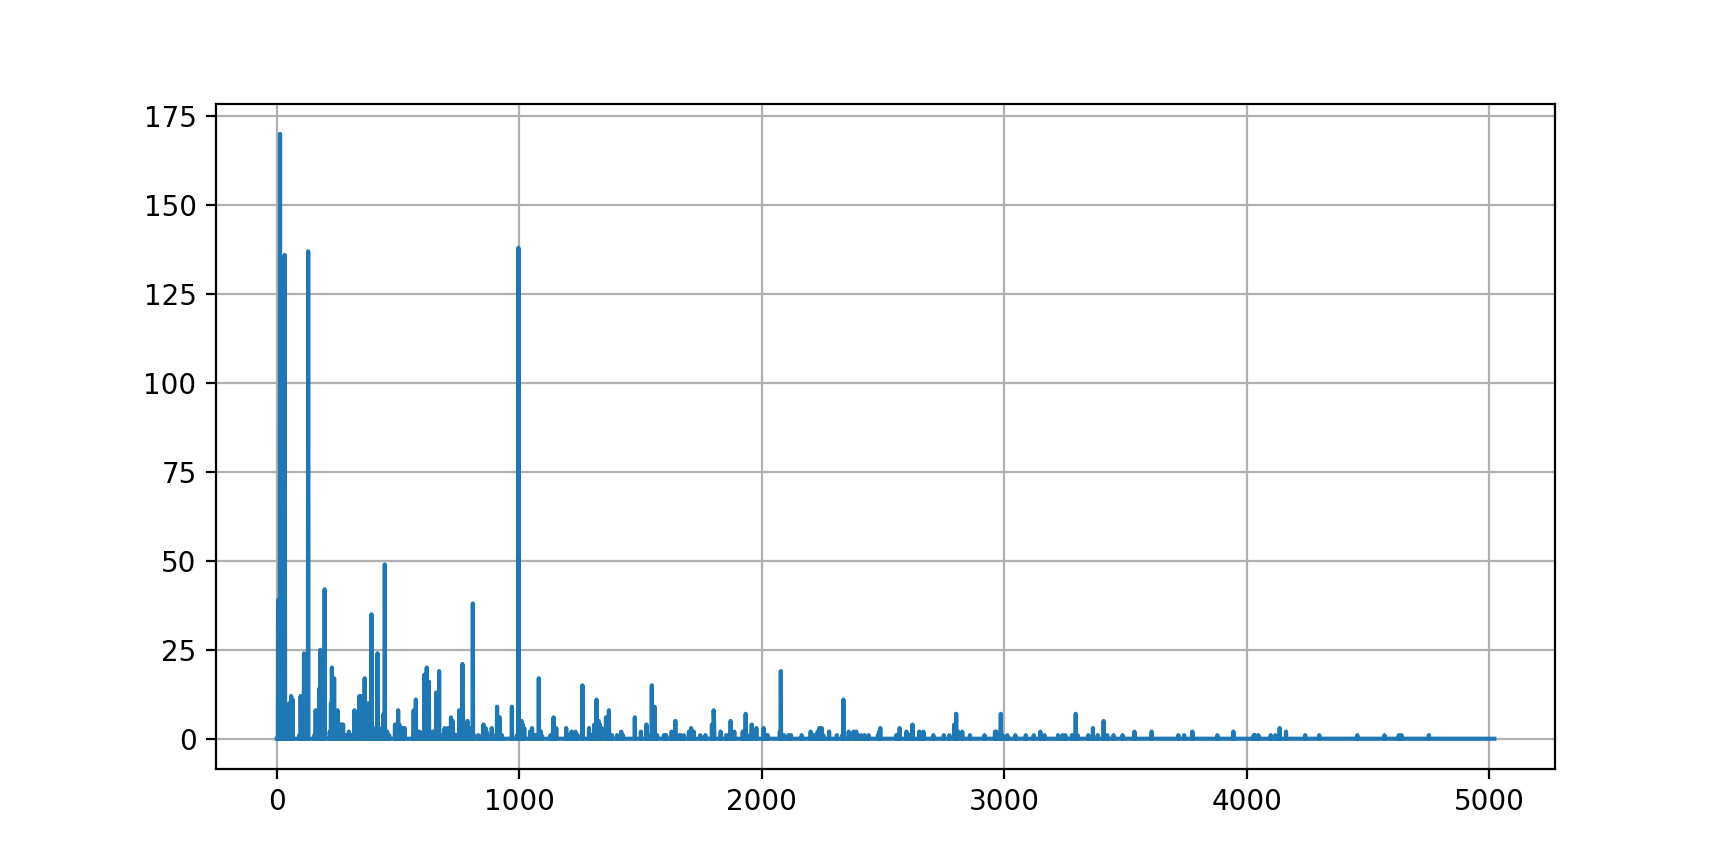

[13, 996, 129, 32, 33, 445, 25, 197, 27, 5, 808, 390, 17, 179, 112, 415, 765, 618, 227, 2078, 669, 608, 362, 236, 1080, 627, 1546, 186, 1260, 174, 657, 102, 59, 351, 340, 98, 573, 1318, 2336, 65, 51, 223, 378, 1557, 908, 767, 658, 969, 320, 1801, 1369, 19, 500, 564, 250, 752, 160, 391, 251, 2985, 168, 1933, 440, 3294, 2801, 114, 1141, 172, 335, 1476, 1802, 919, 1357, 718, 348, 786, 1548, 177, 1009, 1327, 3409, 1643, 1871, 725, 852, 1794, 273, 99, 1524, 261, 255, 1803, 1958, 267, 505, 1332, 361, 358, 356, 783]
[170.0, 138.0, 137.0, 136.0, 92.0, 49.0, 44.0, 42.0, 41.0, 39.0, 38.0, 35.0, 28.0, 25.0, 24.0, 24.0, 21.0, 20.0, 20.0, 19.0, 19.0, 18.0, 17.0, 17.0, 17.0, 16.0, 15.0, 15.0, 15.0, 14.0, 13.0, 12.0, 12.0, 12.0, 12.0, 12.0, 11.0, 11.0, 11.0, 11.0, 10.0, 10.0, 10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.

In [19]:
def plotPathVariety(closest_path_index, n):
    variety=np.zeros(n)
    for i in range(len(closest_path_index)):
        pth=closest_path_index[i]
        if (pth!=-1):
            variety[pth]+=1
    fig = plt.figure(figsize=.9*plt.figaspect(1/2))
    ax = fig.add_subplot(111)
    #ax.plot(range(len(variety)), np.flipud(np.sort(variety)));
    ax.plot(range(len(variety)), variety);
    plt.grid(True)
    return variety

variety=plotPathVariety(closest_path_index, DiverseCplrK.shape[0])
print(np.flipud(np.argsort(variety)).tolist()[0:100])
print(np.flipud(np.sort(variety)).tolist()[0:100])

0.00834515140399259


<IPython.core.display.Javascript object>


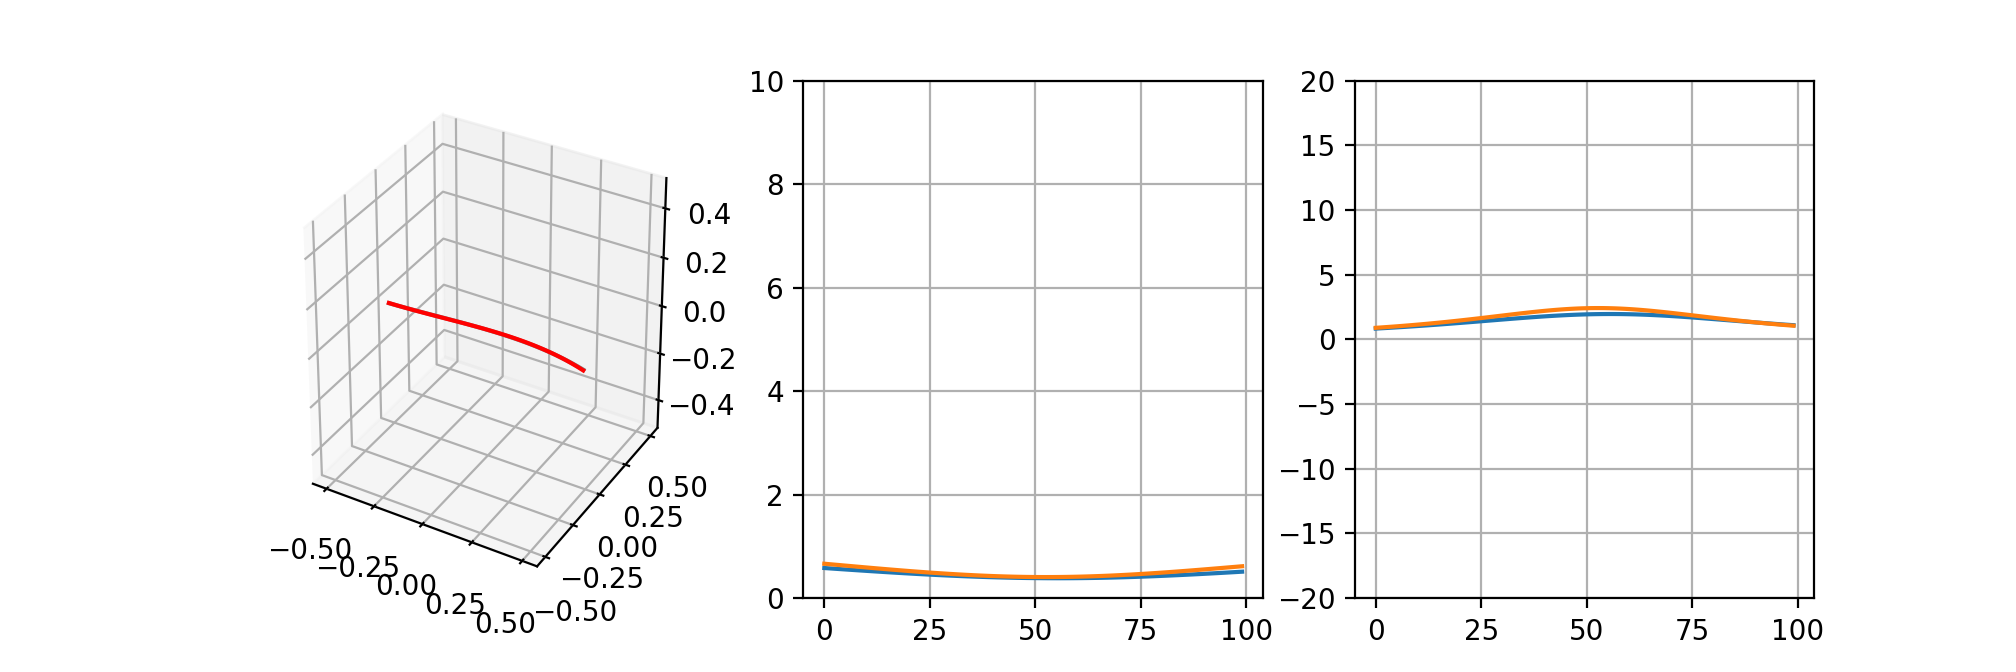

In [33]:
# Example of similar curvature path
def plotCurvComparison(path1, path2):
    K1,T1=calcCurvatureTorsion(path1)
    K2,T2=calcCurvatureTorsion(path2)
    diff_ij,flip=compareCurvTorMetric(K1, K2, T1, T2)
    print(diff_ij)
    #plotFrenetDesc(path1,K1,T1)
    #plotFrenetDesc(path2,K2,T2)
    fig = plt.figure(figsize=.7*plt.figaspect(1/3))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    plotPath(path1, ax, .5)
    plotPath(path2, ax, .5, 'red')

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(range(len(K1)), K1);
    if (flip==0):
        ax.plot(range(len(K2)), K2);
    else:
        ax.plot(range(len(K2)), np.flipud(K2));
    plt.grid(True)
    plt.ylim(0, 10);
    
    ax = fig.add_subplot(1, 3, 3)
    ax.plot(range(len(T1)), T1);
    if (flip==0):
        ax.plot(range(len(T2)), T2);
    else:
        ax.plot(range(len(T2)), np.flipud(T2));
    plt.grid(True)
    plt.ylim(-20, 20);
    plt.show()

closest_path_index=np.array(closest_path_index)
#plotCurvComparison(DiverseCplrK[13],DiverseCplrK[197])
index1=129
index2=np.argwhere(closest_path_index==index1)[0,0]
plotCurvComparison(DiverseCplrK[index1],new_cplr[index2])

<IPython.core.display.Javascript object>


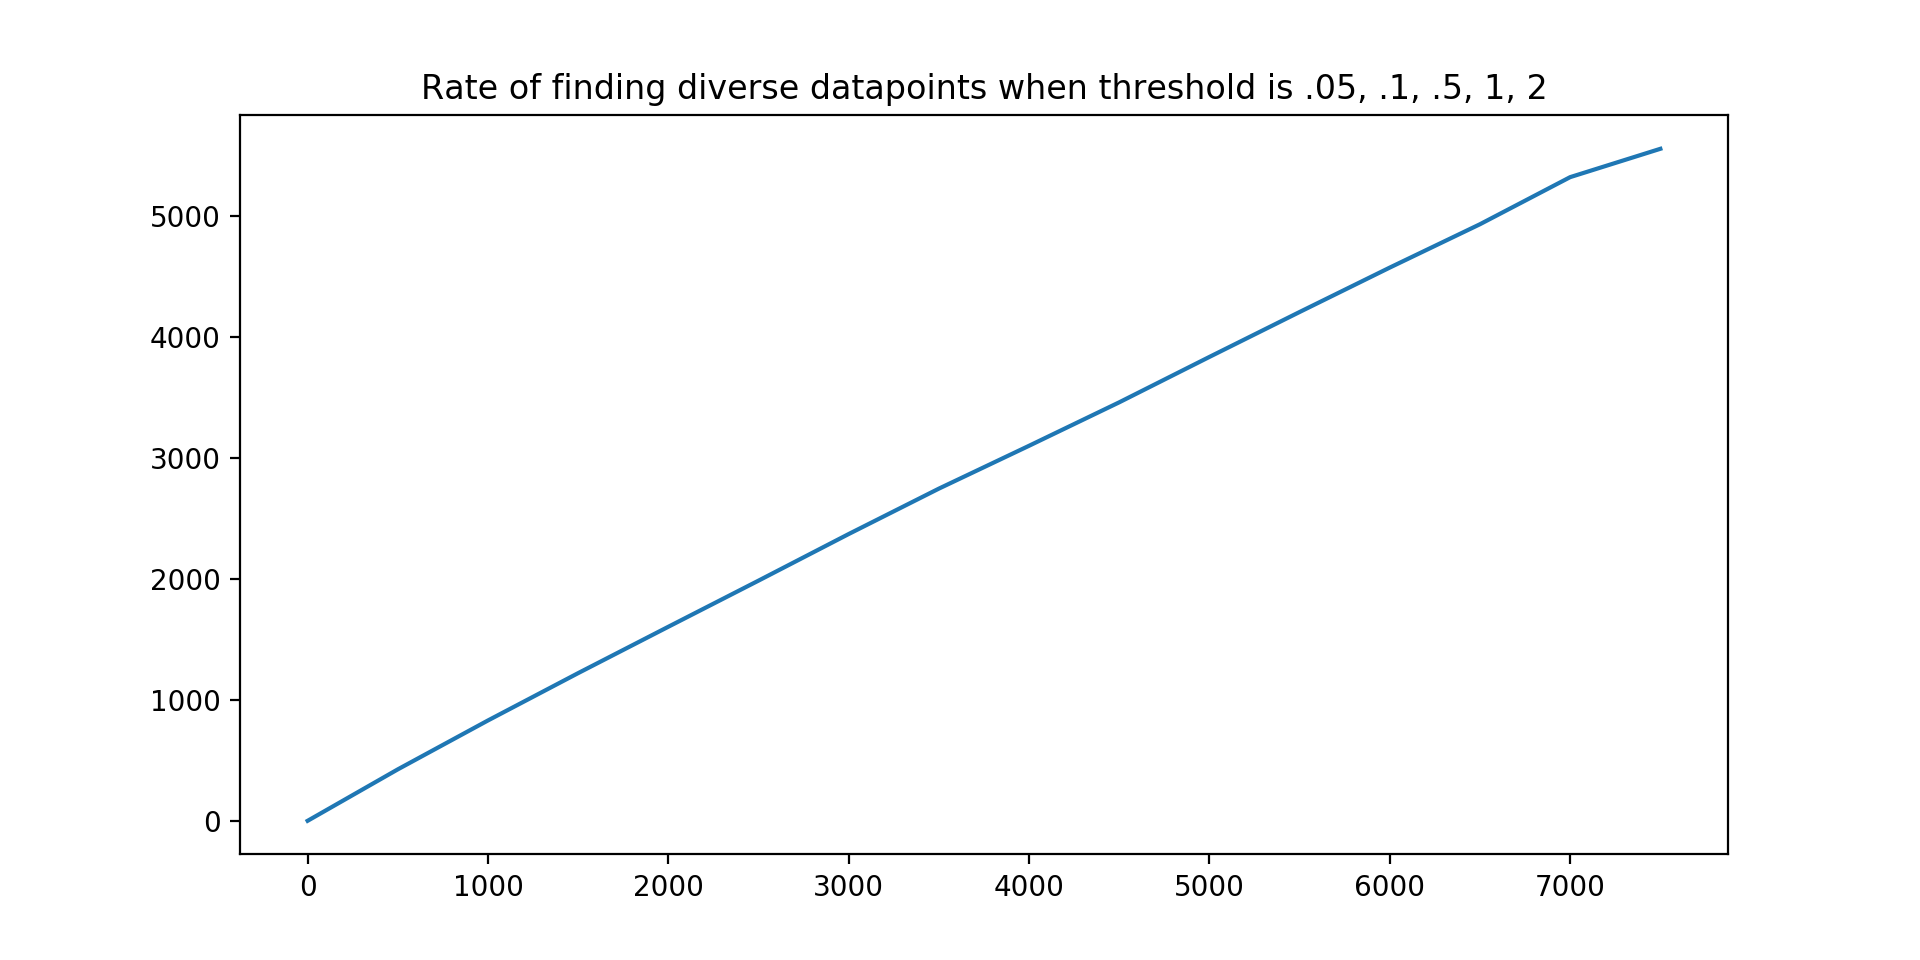

Text(0.5, 1.0, 'Rate of finding diverse datapoints when threshold is .05, .1, .5, 1, 2')

In [36]:
# Rate at which diverse data is added
# Ideally, to represent all of the curves, data should be added until the plot saturates
x=range(0,8000,500)
y_065=[0,399,766,1139,1494,1839,2193,2536,2869,3198,3546,3885,4220,4546,4893,5021]
#y_1=[0,282,529,771,1005,1222,1433,1654,1867,2097,2322,2552,2763,2973,3191,3365]
#y_5=[0,84,163,240,309,371,433,494,545,598,655,718,773,833,893,932]
#y1=[0,46,85,126,168,198,226,260,286,318,354,390,425,456,482,505]
#y2=[0,23,46,66,90,105,122,138,152,171,193,212,237,257,270,283]
fig = plt.figure(figsize=plt.figaspect(1/2))
ax = fig.add_subplot(111)
ax.plot(x,y_05)
#ax.plot(x,y_1)
#ax.plot(x,y_5)
#ax.plot(x,y1)
#ax.plot(x,y2)
ax.set_title("Rate of finding diverse datapoints when threshold is .05, .1, .5, 1, 2")

<IPython.core.display.Javascript object>


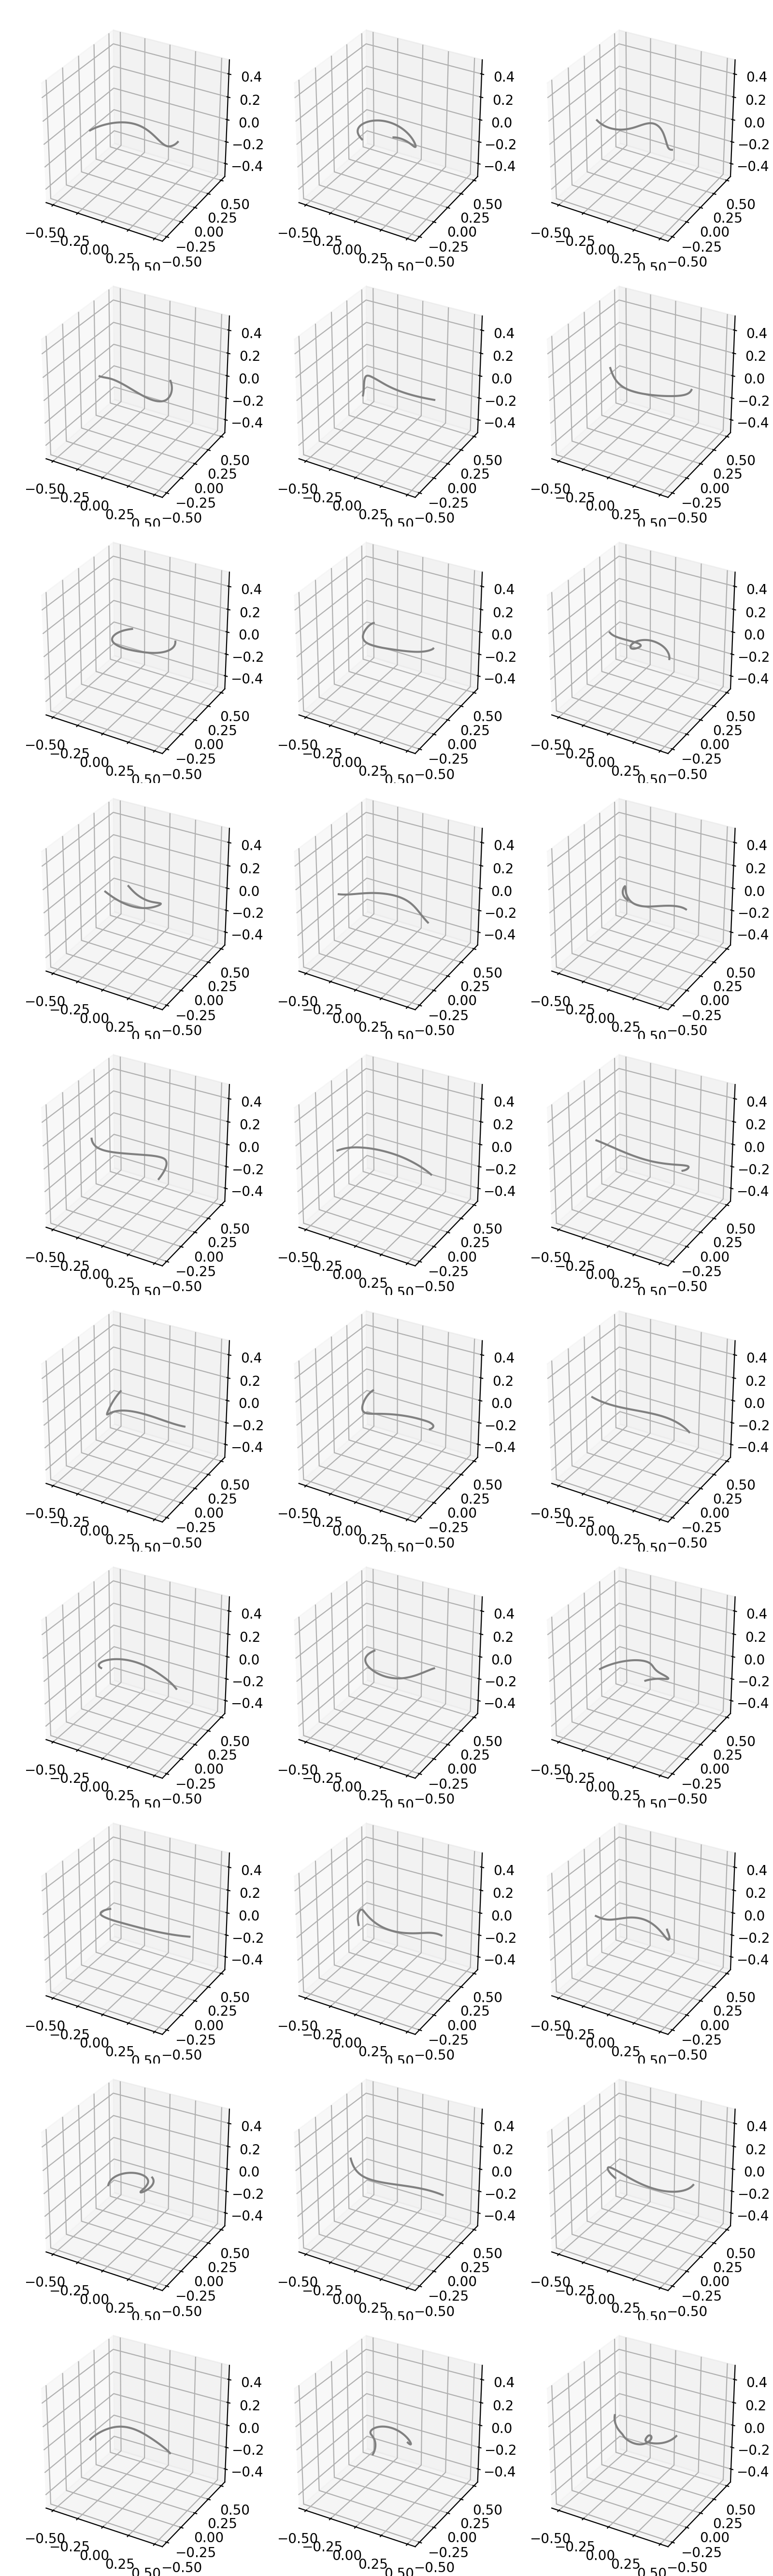

In [37]:
visualizePaths(DiverseCplrK)

In [38]:
np.savez('db_5SS_balanced_s5021', cplrData=DiverseCplrK) 

# Data Augmentation

## Add Mirrored mechanisms

During the normalization process, we ensure that invariance to translation, rotation, scaling and parametrization direction. One another desirable property our model should have is mirror invariance. Thus, adding mirrored paths enhances the robustness of model.

In [40]:
def mirror(Path,Plane):
    if Plane=='xy':
        index=2
    elif Plane=='yz':
        index=1
    elif Plane=='xz':
        index=0
    
    for i in range(len(Path)):
        Path[i][:,index]=-1*Path[i][:,index]
        #Mech[i][:,index]=-1*Mech[i][:,index]
    
    return Path

cplr_x=mirror(DiverseCplrK.copy(),'yz')
cplr_y=mirror(DiverseCplrK.copy(),'xz')
cplr_z=mirror(DiverseCplrK.copy(),'xy')

cplr_aug=np.append(DiverseCplrK,cplr_x,cplr_y,cplr_z)

TypeError: _append_dispatcher() takes from 2 to 3 positional arguments but 4 were given

In [ ]:
Pts1=cplr_x[21]
Pts2=cplr_y[21]
Pts3=cplr_z[21]
fig = plt.figure(figsize=1*plt.figaspect(3/1))
ax = fig.add_subplot(3, 1, 1, projection='3d')
plotPath(Pts1, ax, 1)
ax = fig.add_subplot(3, 1, 2, projection='3d')
plotPath(Pts2, ax, 1)
ax = fig.add_subplot(3, 1, 3, projection='3d')
plotPath(Pts3, ax, 1)
plt.tight_layout(pad=0)

# Add Partial paths from complete paths

# Add Noise for robust feature extraction

# Store the final Database

In [ ]:
np.savez('db_5SS_s1902_div', cplrData=DiverseCplrPathList, mechData=DiverseMechList) 

In [ ]:
db = np.load('db_5SS_s1902_div.npz')

In [ ]:
db.files

In [ ]:
print(db['cplrData'].shape)
print(db['mechData'].shape)